# Variational Autoencoders (VAEs)

A VAE is a generative model. Given some samples $x$ drawn from a distribution $D$ (our data), we want to approximate the true distribution $p^*(x)$ with a parametrized distribution $p_\theta(x)$ :

given $x \sim D$, we want to optimize for $\theta$ so that $p_\theta(x) \approx p^*(x)$

$p_\theta(x)$ is called the *likelihood*, thus we are in presence of a *Maximum Likelihood Estimation* (MLE) problem.

We assume that each sample of our dataset can be described by a finite set of characteristics called the *latent variables*, that we call $z$. These characteristics are called latent as they are underlying : they capture the variations in our data samples but are not directly observed. To build a better intuition on what latent variables are, consider the following example drawn from [1] :



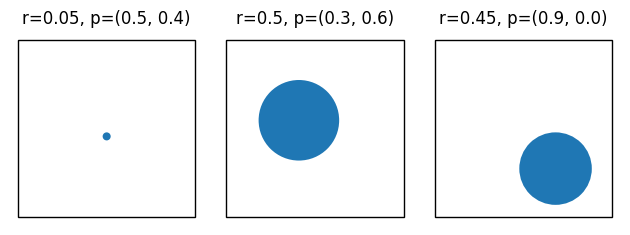

In [104]:
from random import randint

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

num_examples = 3

fig, axs = plt.subplots(1, num_examples)

for ax_index in range(num_examples):
    radius = randint(1, 10) / 20
    position = (randint(0, 10) / 10, randint(0, 10) / 10)

    ax = axs[ax_index]
    ax.set_aspect("equal", "box")
    ax.add_artist(mpatches.Circle(position, radius))
    ax.add_artist(mpatches.Rectangle((-0.6, -0.6), width=2.2, height=2.2, fill=False))

    ax.set_xlim((-0.7, 1.7))
    ax.set_ylim((-0.7, 1.7))
    ax.set_axis_off()

    ax.set_title(f"r={radius}, p={position}")

fig.tight_layout()

In the example above, our dataset is composed of images of blue circles ; the underlying characteristics of any given circle are its radius and its position. Those two latent variables are not directly observed on our images, although they can be inferred. On a more complex case like handwritten digits, latent variables could be the size of the stroke, the position, the stroke style, ...

It now appears that each and every sample can be described in the *data space* or the *latent space*. A VAE is able to perform both inference and generation :

* **inference** : infer the latent variables $z$ from the data point $x$ i.e computing $p_\theta(z|x)$
* **generation** : generate a data point $x$ from a the latent variables $z$ i.e computing $p_\theta(x|z)$

Remembering we want to adjust our set of parameters $\theta$ such that we maximise our likelihood $p_\theta(x)$ for any data point $x$, we can write the marginal likelihood as :


\begin{align*}

p_\theta(x) & = \int_z p_\theta(x, z) dz \\

& = \int_z p_\theta(z) p_\theta(x|z) dz

\end{align*}

It turns out this integral is intractable : there are no analytical solutions and its numerical computation require an amount of samples that grow exponentially with the number of latent variables.

However, Bayes can bail us out of this seemingly impossible situation :

\begin{align*}

p_\theta(x) & = \frac{p_\theta(x, z)}{p_\theta(z|x)} \\

& = \frac{p_\theta(z) p_\theta(x|z)}{p_\theta(z|x)}

\end{align*}

where :

* $p_\theta(x|z)$ is the likelihood
* $p_\theta(x)$ is the marginal likelihood (marginalized over all possible $z$)
* $p_\theta(z)$ is the *prior* distribution (it can be understood as the probability of our model before having seen any data)
* $p_\theta(z|x)$ is the *posterior* distribution



## Sources

* [1] [Understanding Variational Autoencoders (VAEs)](https://youtu.be/HBYQvKlaE0A?si=ttZuI24itPkk6Efz)